# Load Modules

In [1]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import sklearn.linear_model
import sklearn.metrics
import tqdm
from flax import nnx
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
data = load_breast_cancer()
# print(data["DESCR"])

X, y = data["data"], data["target"].reshape(-1, 1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape

((455, 30), (114, 30))

# Modeling

In [3]:
class LogisticRegressor(nnx.Module):
    def __init__(self, din: int, rngs: nnx.Rngs):
        self.linear = nnx.Linear(din, 1, rngs=rngs)

    def __call__(self, x: jax.Array):
        y = nnx.sigmoid(self.linear(x))
        return y

# Training

In [4]:
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        logits = model(x)
        loss = optax.losses.sigmoid_binary_cross_entropy(logits, y).mean()
        return loss

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

In [5]:
def train_loop(model, optimizer, X, y, n_epochs=32, n_batch_size=32):
    all_ilocs = np.arange(len(X))
    n_split = len(all_ilocs) // n_batch_size

    with tqdm.trange(1, n_epochs + 1) as progress_bar:
        for epoch in progress_bar:
            ilocs_batches = jnp.array_split(
                jax.random.permutation(jax.random.PRNGKey(epoch), all_ilocs),
                n_split,
            )

            batch_loss = np.zeros(len(ilocs_batches))
            for i, _ilocs in enumerate(ilocs_batches):
                batch_loss[i] = train_step(model, optimizer, X[_ilocs], y[_ilocs])

            progress_bar.set_postfix(dict(epoch_loss=f"{batch_loss.mean():.3f}"))

In [6]:
model = LogisticRegressor(X_train.shape[1], rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1.0e-3))

train_loop(model, optimizer, X_train, y_train, n_epochs=1000, n_batch_size=64)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.91it/s, epoch_loss=0.460]


# Evaluation

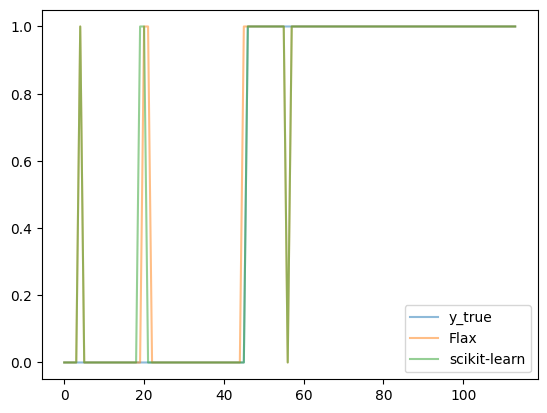

In [7]:
# Baseline models
lr = sklearn.linear_model.LogisticRegression().fit(X_train, y_train.ravel())


# Predictions
preds_flax = (model(X_test).ravel() > 0.5).astype(int)
preds_lr = lr.predict(X_test)

# Plots
_ix = np.argsort(y_test.ravel())
plt.plot(y_test[_ix], label="y_true", alpha=0.5)
plt.plot(preds_flax[_ix], label="Flax", alpha=0.5)
plt.plot(preds_lr[_ix], label="scikit-learn", alpha=0.5)
plt.legend()